In [9]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
from keras.layers import Concatenate, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
import numpy as np
import torch
import torch.nn as nn                 # the torch module to implement the Neural Networks
import torch.nn.parallel              # for parallel computations
import torch.optim as optim           # for optimizers
import torch.utils.data               # tools
from torch.autograd import Variable   # for Stochastic Gradient Descent
import random as rnd

df = pd.read_csv('netflix_price.csv').astype({
    'movie_id' : 'int16',
    'user_id' : 'int32',
    'rating' : 'int8',
    'date' : 'datetime64[us]'
})

print(df)
df['user_id'] = df['user_id'].astype(np.uint32)
df['movie_id'] = df['movie_id'].astype(np.uint16)
df['rating'] = df['rating'].astype(np.uint8)

print(df.shape)


         Unnamed: 0  user_id  rating       date  movie_id
0                 0  1488844       3 2005-09-06         1
1                 1   822109       5 2005-05-13         1
2                 2   885013       4 2005-10-19         1
3                 3    30878       4 2005-12-26         1
4                 4   823519       3 2004-05-03         1
...             ...      ...     ...        ...       ...
5010194         755  1954284       5 2005-05-04      1000
5010195         756   299636       2 2005-10-27      1000
5010196         757  1635449       1 2005-01-10      1000
5010197         758   906984       4 2005-05-13      1000
5010198         759  2633357       3 2005-10-13      1000

[5010199 rows x 5 columns]
(5010199, 5)


In [10]:
# Get only the most popular movies
df_movie_summary = df.groupby('movie_id')['rating'].agg(['count'])
sorted_movies = df_movie_summary.sort_values(by='count', ascending=False)
top_movies = sorted_movies.head(int(len(df_movie_summary) * .08))  # Select the top N movies by rating count
top_movies_ids = top_movies.index.tolist()  # Get the movie IDs of the top N movies
print(f'Number of Movies reduced to {(len(top_movies_ids) / len(df_movie_summary)) * 100}% from {len(df_movie_summary)} to {len(top_movies_ids)}')

# Get only the most popular users
df_customer_summary = df.groupby('user_id')['rating'].agg(['count'])
sorted_customers = df_customer_summary.sort_values(by='count', ascending=False)
top_customers = sorted_customers.head(int(len(df_customer_summary) * .08))  # Select the top N customers by rating count
top_customer_ids = top_customers.index.tolist()  # Get the customer IDs of the top N customers
print(f'Number of Customers reduced to {(len(top_customer_ids) / len(df_customer_summary))* 100}% from {len(df_customer_summary)} to {len(top_customer_ids)}')

print('Before Trim Shape: {}'.format(df.shape))

# Trim the dataset based on the most popular movies and users
df = df[df['movie_id'].isin(top_movies_ids)]
df = df[df['user_id'].isin(top_customer_ids)]
print('After Trim Shape: {}'.format(df.shape))


Number of Movies reduced to 2.0% from 1000 to 20
Number of Customers reduced to 1.9999752814821223% from 404555 to 8091
Before Trim Shape: (5010199, 5)
After Trim Shape: (123667, 5)


In [11]:
num_movies = df['movie_id'].nunique()
num_users = df['user_id'].nunique()

unique_users = df['user_id'].unique()
unique_movies = df['movie_id'].unique()
unique_users.sort()
unique_users.sort()

print("Users: ", num_users)
print("Movies :",num_movies)

x = df[['user_id','rating', 'movie_id']].values
y = df['rating'].values
print(df)
x_training, x_test, y_training, y_test = train_test_split(x, y, test_size=0.2)

# Convert to a users x movies matrix
def transform(data):
    new_data = []
    for cust_id in unique_users:
        # Get all movies from this user
        movie_ids = data[:,2][data[:,0]==cust_id]
        # Get all ratings from this user
        rating_ids = data[:,1][data[:,0]==cust_id]
        ratings = np.zeros(num_movies)
        # Fill in the user's row with the ratings
        for movie_id in movie_ids :
          idx_in_rating_list =  list(unique_movies).index(movie_id)
          ratings[idx_in_rating_list] = rating_ids[list(movie_ids).index(movie_id)]
        new_data.append(list(ratings))

    return new_data

x_training_df_before_transform = x_training

x_training = np.array(x_training)
x_test = np.array(x_test)
x_training = transform(x_training)
x_test_matrix = transform(x_test)

Users:  8091
Movies : 20
         Unnamed: 0  user_id  rating       date  movie_id
92801             3  1990901       4 2004-05-24        30
92806             8   306466       3 2004-04-02        30
92814            16  1987434       2 2005-07-15        30
92821            23  1468812       5 2004-04-05        30
92834            36  2422606       4 2004-05-11        30
...             ...      ...     ...        ...       ...
4945527       89940    63786       4 2005-07-04       985
4945548       89961  1677862       1 2005-10-05       985
4945554       89967   502274       4 2005-10-12       985
4945561       89974   477466       4 2005-10-17       985
4945577       89990  2180413       4 2005-12-02       985

[123667 rows x 5 columns]


RMSE:  1.2363919263537273


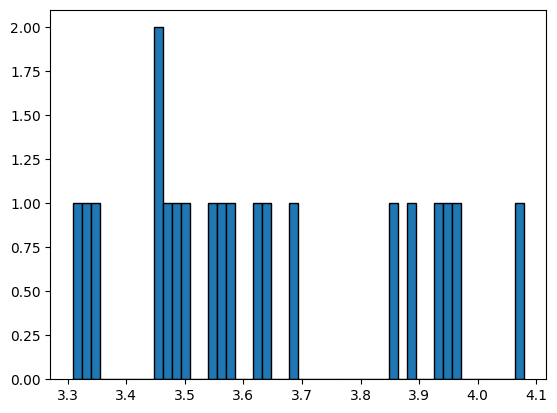

In [12]:
# Get the average rating for each movie
averages = {}
for movie in unique_movies:
    averages[movie] = df[df['movie_id'] == movie]['rating'].mean()

plt.hist(averages.values(), bins=50, edgecolor='black')   

from scipy import stats

# Get the percentile of each movies average rating
def percentile_to_rating(percentile):
    rating = 0
    if(percentile < .05):
        rating = 1
    elif(percentile < .10):
        rating = 2
    elif(percentile < .43):
        rating = 3
    elif(percentile < .78):
        rating = 4
    else:
        rating = 5
    return rating    

average_score_results = []
# Predict the score of the movie based on the percentile of it's average rating
for row in x_test:
   average = averages[row[2]]
   percentile = stats.percentileofscore(list(averages.values()), average) 
   average_score_results.append(percentile_to_rating(percentile/100))

# Find the RMSE of the classifier
MSE = mean_squared_error(y_test, average_score_results)
print("RMSE: ", pow(MSE,1/2))


0.14533622562885284 1
epoch: 1 loss: 0.14533622562885284
0.7268508076667786 1
epoch: 2 loss: 0.7268508076667786
0.2538082003593445 1
epoch: 3 loss: 0.2538082003593445
[[ 853087       4     312]
 [ 530763       5     312]
 [2648869       2     985]
 ...
 [ 951446       3     758]
 [2468881       5     788]
 [ 424387       2     985]]


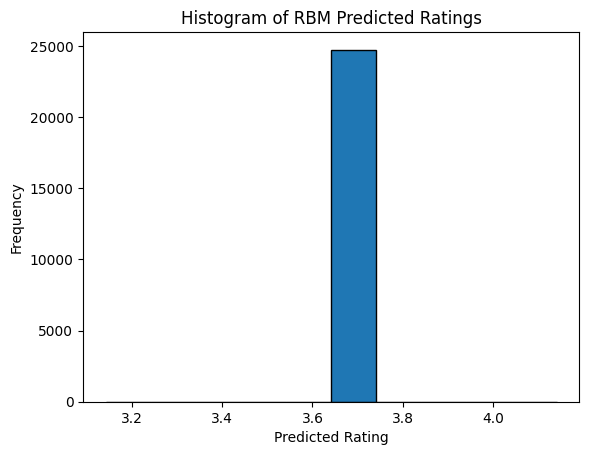

RMSE:  1.0467798104888528


In [18]:
x_training_tensor = torch.FloatTensor(x_training)
x_test_tensor = torch.FloatTensor(x_test_matrix)

x_test_tensor[x_test_tensor == 0] = -1
x_test_tensor[x_test_tensor == 1] = 0
x_test_tensor[x_test_tensor == 2] = 0
x_test_tensor[x_test_tensor > 2] = 1

x_training_tensor[x_training_tensor == 0] = -1
x_training_tensor[x_training_tensor == 1] = 0
x_training_tensor[x_training_tensor == 2] = 0
x_training_tensor[x_training_tensor > 2] = 1

class RBM():

    # Initialize the weights and biases
    def __init__(self, visible_nodes, hidden_nodes):
        self.Weights = torch.randn(hidden_nodes, visible_nodes)
        self.bias = torch.randn(1, hidden_nodes)
        self.bias2 = torch.randn(1, visible_nodes)

    # Sample the hidden nodes    
    def sample_hidden_nodes(self, visible_neurons):
        wx = torch.mm(visible_neurons, self.Weights.t())
        activation = wx + self.bias.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    # Sample the visible nodes
    def sample_visible_nodes(self, y):
        wy = torch.mm(y, self.Weights)
        activation = wy + self.bias2.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    # Train the RBM
    def train(self, input_ratings_vector, visible_nodes_k_samples, probability_vector, prob_hidden_nodes_k_samples):
        self.Weights += (torch.mm(input_ratings_vector.t(), probability_vector) - 
                   torch.mm(visible_nodes_k_samples.t(), prob_hidden_nodes_k_samples)).t()
        self.bias2 += torch.sum((input_ratings_vector-visible_nodes_k_samples), 0)
        self.bias += torch.sum((probability_vector-prob_hidden_nodes_k_samples), 0)


visible_nodes = len(x_training_tensor[0])
hidden_nodes = 300                    
batch_size = 300
rbm = RBM(visible_nodes, hidden_nodes)
optimizer = torch.optim.Adam([rbm.Weights, rbm.bias, rbm.bias2], lr=0.001)
num_epoch = 3 

import torch.nn as nn

loss_function = nn.MSELoss()

for epoch in range(1, num_epoch+1):
    train_loss = 0                      
    s = 0                          
    
    # For each user in the training set
    for user_number in range(0, num_users - batch_size, batch_size):
        id_user = unique_users[user_number]
        id_end_user = unique_users[user_number + batch_size]
        visible_node = x_training_tensor[id_user:id_end_user]
        movie_vector = x_training_tensor[id_user:id_end_user]
        # Get the probability of the hidden nodes
        probability_hidden_node,_ = rbm.sample_hidden_nodes(movie_vector)
        
        # Perform Gibbs Sampling
        for gibbs_samples in range(10):
            _,hidden_nodes_at_k = rbm.sample_hidden_nodes(visible_node)
            _,visible_node = rbm.sample_visible_nodes(hidden_nodes_at_k)
            visible_node[movie_vector<0] = movie_vector[movie_vector<0] 
    
        phk,_ = rbm.sample_hidden_nodes(visible_node)
        rbm.train(movie_vector, visible_node, probability_hidden_node, phk)
        
        # Reset the gradients
        optimizer.zero_grad()

        # Calculate the loss
        loss = loss_function(movie_vector[movie_vector >= 0], visible_node[movie_vector >= 0])
        if(not loss.isnan()):
            train_loss+=loss.item()
            s += 1

        optimizer.step()
    print(train_loss, s)
    if(s > 0):
        print('epoch: ' + str(epoch) + ' loss: ' + str(train_loss/s) )

# Convert a user x movie matrix to a list of ratings
def get_test_results_from_matrix(test, results) :
    test_results = []
    print(test)
    for entry in test:
        user_id = entry[0]
        movie_id = entry[2]
        user_idx = list(unique_users).index(user_id)
        movie_idx = list(unique_movies).index(movie_id)
        prediction = results[user_idx][movie_idx]
        test_results.append(prediction)
    return test_results

def predict(rbm_model, input_data):
    _, hidden_nodes = rbm_model.sample_hidden_nodes(input_data)
    probabilities, visible_nodes = rbm_model.sample_visible_nodes(hidden_nodes)
    return probabilities, visible_nodes

# Map probabilities of liking a movie to a rating
def map_probabilities(probabilities):
    final_predictions = []
    final_probabilities = []
    for user_row in probabilities :
        user_predictions = np.zeros(len(user_row))
        user_probs = np.zeros(len(user_row))
        for i, user_rating in enumerate(user_row) :
            prediction = 0
            if user_rating < 0.03 :
                prediction = 1
            elif user_rating < 0.25 :
                prediction = 2
            elif user_rating < 0.44 :
                prediction = 3
            elif user_rating < 0.98 :
                prediction = 5
            else :
                prediction = 4
            user_predictions[i] = prediction
            user_probs[i] = user_rating
        final_predictions.append(user_predictions)
        final_probabilities.append(user_probs)
    return final_predictions, final_probabilities

# Get the probabitilies that the user will like a movie
probabilities, results = predict(rbm, x_test_tensor)

# Map the probabilities to ratings
new_results, final_probs = map_probabilities(probabilities)

# Convert the user x movie matrix to a list of ratings
rbm_probabilities = get_test_results_from_matrix(x_test, final_probs)

# Make a linear regression model to predict the ratings
from sklearn.linear_model import LinearRegression
rbm_X = np.array(rbm_probabilities).reshape(-1, 1)
rbm_y = np.array(y_test).reshape(-1, 1)
rbm_model = LinearRegression()
rbm_model.fit(rbm_X, rbm_y)

# Make predictions on the test set
rbm_predictions = rbm_model.predict(rbm_X)

# Find the RMSE of the classifier
MSE = mean_squared_error(y_test, rbm_predictions)

plt.hist(rbm_predictions, bins=10, edgecolor='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of RBM Predicted Ratings')
plt.show()

print("RMSE: ", pow(MSE,1/2))



[[3. 3. 1. ... 0. 4. 1.]
 [0. 5. 0. ... 5. 0. 5.]
 [0. 5. 4. ... 4. 4. 4.]
 ...
 [0. 4. 5. ... 3. 0. 2.]
 [0. 5. 4. ... 3. 5. 0.]
 [0. 0. 5. ... 4. 4. 2.]]


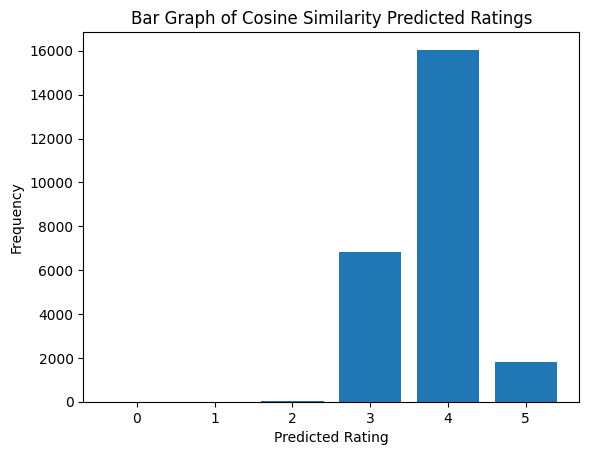

RMSE:  1.0973294692561586


In [14]:
from scipy.spatial.distance import cosine
from scipy import stats

# Turn all 0s to NaNs to ignore them
x_training_array = np.array(x_training, dtype=float)
x_training_array[x_training_array == 0] = np.nan

# Find the mean rating for each user
user_means = np.nanmean(x_training_array, axis=1)

# Normalize the ratings by subtracting the mean rating for each user
zero_centered_users = np.nan_to_num(x_training_array - user_means.reshape(-1, 1), nan=0)

# Find the cosine similarity between each user
from sklearn.neighbors import NearestNeighbors
nn_model = NearestNeighbors(metric='cosine')
nn_model.fit(zero_centered_users)
distances, indices = nn_model.kneighbors(zero_centered_users, n_neighbors=50)

import numpy as np
cosine_mode_predictions = []

# For each entry in the test set, predict the rating based on the cosine similarity
for row in x_test:
    userId = row[0]
    movie_id = row[2]
    index = list(unique_users).index(userId)
    user = x_training[index]
    similar_indices = indices[index]
    movie_ratings = []
    # Get the ratings of the most similar users
    for value in similar_indices:
        similar_user_ratings = x_training[value]
        rating = similar_user_ratings[list(unique_movies).index(movie_id)]
        if(rating > 0):
            movie_ratings.append(rating)
    if(len(movie_ratings) == 0):
        cosine_mode_predictions.append(4)
    else:
        # Predict the rating based on the mode of the ratings of the most similar users
        cosine_mode_predictions.append(stats.mode(movie_ratings).mode)

# Find the RMSE of the classifier
MSE = mean_squared_error(y_test, cosine_mode_predictions)
cosine_counts = np.bincount(cosine_mode_predictions)
cosine_ratings = np.arange(len(cosine_counts))
plt.bar(cosine_ratings, cosine_counts)
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Bar Graph of Cosine Similarity Predicted Ratings')
plt.show()
print("RMSE: ", pow(MSE,1/2))

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ANOVA for Cluster 0 (Training Set):
F-statistic: 4.831689467783399, p-value: 0.027943526903897686

ANOVA for Cluster 1 (Training Set):
F-statistic: 8.744364189135016, p-value: 0.0031063276652101342

ANOVA for Cluster 2 (Training Set):
F-statistic: 2.043873230283242, p-value: 0.15282322333268034

ANOVA for Cluster 3 (Training Set):
F-statistic: 2.5794241519958314, p-value: 0.1082642010994556

ANOVA for Cluster 4 (Training Set):
F-statistic: 0.12030033407924436, p-value: 0.7287097102694988

ANOVA for Cluster 5 (Training Set):
F-statistic: 1.7263026784000486, p-value: 0.1888867827526894

ANOVA for Cluster 6 (Training Set):
F-statistic: 1.4488967444758947, p-value: 0.22870791363048582

ANOVA for Cluster 7 (Training Set):
F-statistic: 0.10375461016405038, p-value: 0.7473703191347199

ANOVA for Cluster 8 (Training Set):
F-statistic: 7.062075695078659, p-value: 0.007874519024082227

ANOVA for Cluster 9 (Training Set):
F-statistic: 1.36895110302343, p-value: 0.24199497813368645

ANOVA for Clus

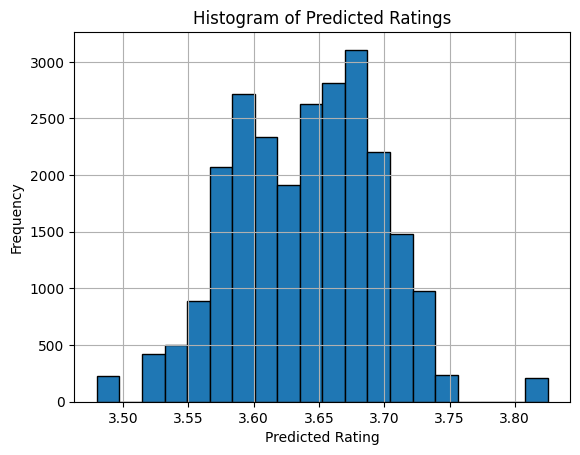

In [15]:
from sklearn.cluster import KMeans
from scipy.stats import f_oneway

cluster_train_data = pd.DataFrame(x_training_df_before_transform, columns = ['user_id', 'rating', 'movie_id'])

cluster_test_data = pd.DataFrame(x_test, columns = ['user_id', 'rating', 'movie_id'])

# Convert the ratings matrix to a NumPy array
train_ratings_matrix_array = x_training

# Apply k-means clustering on the training set
num_clusters = 100  # Adjust the number of clusters based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_train_data['cluster'] = kmeans.fit_predict(cluster_train_data[['user_id', 'rating', 'movie_id']])

# Perform ANOVA on the training set clusters
most_significant_cluster = None
min_p_value = float('inf')  # Initialize with a large value

for cluster in range(num_clusters):
    cluster_ratings = cluster_train_data[cluster_train_data['cluster'] == cluster]['rating']
    
    # Check if there are at least two unique ratings within the cluster
    if len(cluster_ratings.unique()) > 1:
        print(f"ANOVA for Cluster {cluster} (Training Set):")
        f_statistic, p_value = f_oneway(cluster_ratings, cluster_train_data['rating'])
        print(f"F-statistic: {f_statistic}, p-value: {p_value}")
        
        # Update the most significant cluster if needed
        if p_value < min_p_value:
            min_p_value = p_value
            most_significant_cluster = cluster
        
        print()
    else:
        print(f"Insufficient data for ANOVA in Cluster {cluster} (Training Set)")

# Print the most significant cluster
print(f"The most significant cluster is Cluster {most_significant_cluster} with p-value {min_p_value}")

cluster_test_data['cluster'] = kmeans.predict(cluster_test_data[['user_id', 'rating', 'movie_id']])

# Merge test_data with the cluster means from the training set
test_data_with_means = cluster_test_data.merge(cluster_train_data.groupby('cluster')['rating'].mean().reset_index(), on='cluster', how='left')
test_data_with_means.rename(columns={'rating_x': 'actual_rating', 'rating_y': 'predicted_rating'}, inplace=True)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data_with_means['actual_rating'], test_data_with_means['predicted_rating']))
anova_predictions = list(test_data_with_means['predicted_rating'])
print(f"Root Mean Squared Error (RMSE): {rmse}")

test_data_with_means['predicted_rating'].hist(bins=20, edgecolor='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Ratings')
plt.show()


Predicted rating for user  on movie 10: 1.91980556893899


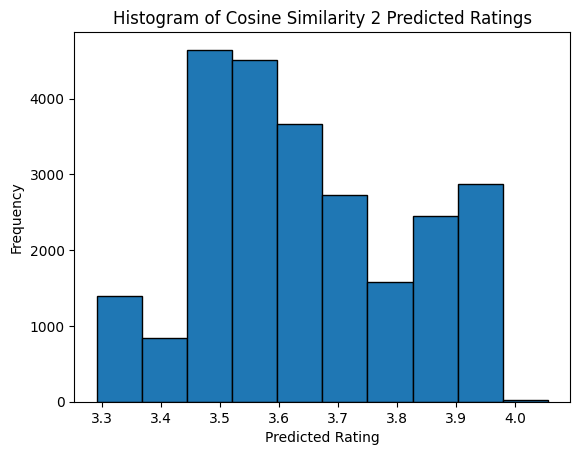

Root Mean Squared Error (RMSE): 1.015824925141526


In [16]:
# Calculating cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(x_training, dense_output=False)

x_training_df = pd.DataFrame(x_training)

def predict_ratings(user_id, movie_id):
    user_row = x_training_df.iloc[:,movie_id]
    sim_scores = user_similarity[user_id]
    # movie_ratings = movie_feat.loc['movie_id']==movie_id]

    # Calculate the weighted sum of ratings
    if(sim_scores.sum() == 0):
        return 4
    prediction = user_row.dot(sim_scores) / sim_scores.sum()
    return prediction

# Example: Predicting rating for user_id=10, movie_id=10
predicted_rating = predict_ratings(100, 10)

print(f"Predicted rating for user  on movie 10: {predicted_rating}")

cosine_predictions_2 = []
original_ratings = []

for row in x_test:
  user_id = row[0]
  movie_id = row[2]
  user_id_loc = list(unique_users).index(user_id)
  movie_id_loc = list(unique_movies).index(movie_id)
  prediction = predict_ratings(user_id_loc, movie_id_loc)
  cosine_predictions_2.append(prediction)
  original_ratings.append(row[1])

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
cosine_X = np.array(cosine_predictions_2).reshape(-1, 1)
cosine_y = np.array(original_ratings).reshape(-1, 1)
model = LinearRegression()
model.fit(cosine_X, cosine_y)

# Make predictions on the cosine predictions
cosine_average_predictions = model.predict(cosine_X)

plt.hist(cosine_average_predictions, bins=10, edgecolor='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarity 2 Predicted Ratings')
plt.show()

mse = mean_squared_error(cosine_average_predictions, original_ratings, squared=False)
print(f"Root Mean Squared Error (RMSE): {mse**0.5}")

Amount of Predictions: 24734


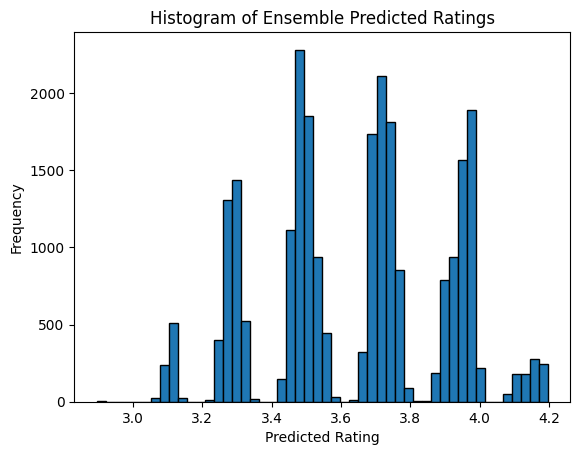

Final RMSE:  1.0143937982385771


In [19]:
ensemble_predictions = []
averages = []
print("Amount of Predictions:", len(rbm_predictions))
for i, rating in enumerate(rbm_predictions):
    ratings = []
    ratings.append(rating)
    ratings.append(cosine_mode_predictions[i])
    ratings.append(average_score_results[i])
    ratings.append(anova_predictions[i])
    ratings.append(cosine_average_predictions[i])
    average = sum(ratings) / len(ratings)
    averages.append(average)


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
X = np.array(averages).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y_test)

# Make predictions on the test set
ensemble_predictions = model.predict(X)

import matplotlib.pyplot as plt
plt.hist(ensemble_predictions, bins=50, edgecolor='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ensemble Predicted Ratings')
plt.show()

MSE = mean_squared_error(y_test, ensemble_predictions)
print("Final RMSE: ", pow(MSE,1/2))    

# 5 mins on 96%
# 11 mins on 94%
# 36 mins on 92%
# 42 mins on 91%
# 1h 40m on 93% users 50% movies